In [63]:
# Data manipulation and plots
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling and Forecasting
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Preprocessing
# ==============================================================================
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn import set_config
set_config(display="diagram")

# Warnings configuration
# ==============================================================================
import warnings

# Utils and functions
# ==============================================================================
from tqdm.notebook import trange, tqdm
import model_helpers
import RollingForecast

In [64]:
path = '../../data/clean/'
SEED = 12

# 0. Preprocessing

## Load UNHCR dataset

In [65]:
unhcr = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])
unhcr['year'] = pd.to_datetime(unhcr['year'], format='%Y')
unhcr["year"] = unhcr["year"].dt.year
unhcr = unhcr.sort_values(by=['iso_o', 'iso_d','year'], ascending=[True, True, True])
unhcr = unhcr.reset_index(drop=True)
unhcr = unhcr.drop(columns=['Country_o', 'Country_d'])
unhcr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955500 entries, 0 to 955499
Data columns (total 46 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   iso_o             955500 non-null  object 
 1   iso_d             955500 non-null  object 
 2   year              955500 non-null  int64  
 3   pop_o             955500 non-null  float64
 4   CPI_o             955500 non-null  float64
 5   GDP_PP_o          955500 non-null  float64
 6   GDP_PPP_o         955500 non-null  float64
 7   island_o          955500 non-null  int64  
 8   area_o            955500 non-null  float64
 9   landlocked_o      955500 non-null  int64  
 10  PR_o              955500 non-null  int64  
 11  CL_o              955500 non-null  int64  
 12  typeOfViolence_o  955500 non-null  int64  
 13  best_est_o        955500 non-null  float64
 14  Nyear_conflict_o  955500 non-null  float64
 15  Nyear_log_o       955500 non-null  float64
 16  dead_log_o        95

In [66]:
# Move the "newarrival" column to the end of the DataFrame
newarrival_column = unhcr.pop('newarrival')
unhcr['newarrival'] = newarrival_column

In [67]:
# Store the list of countries to predict
ids = unhcr['Id'].unique().tolist()
len(ids)

38220

In [78]:
# Fill NaN until 2021 with previous values 
unhcr.loc[unhcr['year'] <= 2021, 'newarrival'] = unhcr.loc[unhcr['year'] <= 2021, 'newarrival'].fillna(method='ffill')
has_nan = unhcr.loc[unhcr['year'] <= 2021, 'newarrival'].isnull().sum()
print("UNHCR missing values:", has_nan)

UNHCR missing values: 0


### Subsample

In [68]:
subsample = 0

if subsample == 1:

    # Get the first 10 unique "Id" values
    ids = unhcr['Id'].unique()[38000:]

    # Filter the dataframe for the first 10 "Id" values
    unhcr = unhcr[unhcr['Id'].isin(ids)]
    unhcr

# 2. Modelling

In [69]:
# Important Definitions
start_year = 2018
end_year   = 2021 
lags       = 4     # AR(4)

## 2.1 Naive Model

In [70]:
# Create train/test split
train = unhcr.loc[unhcr.year < start_year]
test = unhcr.loc[(unhcr.year >= start_year) & (unhcr.year <= end_year)]

In [71]:
y_naive = model_helpers.apply_naive_prediction(train, test, target="newarrival", lst_countries=ids,
                                              country_var='Id'
                                              )

In [72]:
data = {'Id': test.Id,
        'year': test.year,
        'fcast_naive': y_naive}
df_forecast_naive = pd.DataFrame(data)

# Create new dataframe with forecasted values
df_forecast = unhcr.loc[unhcr.year <= end_year]
df_forecast = pd.merge(df_forecast, df_forecast_naive, on=['Id', 'year'], how='outer')
df_forecast

,iso_o,iso_d,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,...,contig,comlang_off,comlang_ethno,colony,comcol,col45,smctry,dist,newarrival,fcast_naive
0,ABW,AFG,2000,0.091,3.544,36636.95,0.005,1,193.0,0,...,0,0,0,0,0,0,0,13257.814453,0.0,NaN
1,ABW,AFG,2001,0.091,2.518,37813.88,0.006,1,193.0,0,...,0,0,0,0,0,0,0,13257.814453,0.0,NaN
2,ABW,AFG,2002,0.092,4.162,37198.23,0.005,1,193.0,0,...,0,0,0,0,0,0,0,13257.814453,0.0,NaN
3,ABW,AFG,2003,0.093,2.287,37185.65,0.005,1,193.0,0,...,0,0,0,0,0,0,0,13257.814453,0.0,NaN
4,ABW,AFG,2004,0.095,2.774,39054.94,0.005,1,193.0,0,...,0,0,0,0,0,0,0,13257.814453,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840835,ZWE,ZMB,2017,14.437,3.430,2311.53,0.027,0,390759.0,1,...,1,1,1,0,1,0,0,396.804077,0.0,NaN
840836,ZWE,ZMB,2018,14.642,42.074,2387.04,0.028,0,390759.0,1,...,1,1,1,0,1,0,0,396.804077,2.0,0.0
840837,ZWE,ZMB,2019,14.905,521.150,2200.74,0.025,0,390759.0,1,...,1,1,1,0,1,0,0,396.804077,0.0,2.0
840838,ZWE,ZMB,2020,15.189,348.586,2048.27,0.025,0,390759.0,1,...,1,1,1,0,1,0,0,396.804077,1.0,0.0


## 2.2 Rolling Forecast - AR

In [80]:
# Note that we don't include any exo_var
df_forecast_ar = RollingForecast.one_step_rolling_forecast(main_df=unhcr, id_column="Id", time_column="year", target="newarrival", 
                                                           exo_var=None, start_year=start_year, end_year=end_year, lags=lags)

# Merge with naive forecasts
df_forecast_ar = df_forecast_ar.rename(columns={"fcast":"fcast_ar"})
df_forecast = pd.merge(df_forecast, df_forecast_ar, on=['Id', 'year'], how='outer')
df_forecast = df_forecast[['iso_o','iso_d','year','Id','newarrival','fcast_naive','fcast_ar']]
df_forecast

  0%|          | 0/38220 [00:00<?, ?it/s]

,iso_o,iso_d,year,Id,newarrival,fcast_naive,fcast_ar
0,ABW,AFG,2000,ABWAFG,0.0,NaN,NaN
1,ABW,AFG,2001,ABWAFG,0.0,NaN,NaN
2,ABW,AFG,2002,ABWAFG,0.0,NaN,NaN
3,ABW,AFG,2003,ABWAFG,0.0,NaN,NaN
4,ABW,AFG,2004,ABWAFG,0.0,NaN,NaN
...,...,...,...,...,...,...,...
840835,ZWE,ZMB,2017,ZWEZMB,0.0,NaN,NaN
840836,ZWE,ZMB,2018,ZWEZMB,2.0,0.0,2.324000
840837,ZWE,ZMB,2019,ZWEZMB,0.0,2.0,1.046909
840838,ZWE,ZMB,2020,ZWEZMB,1.0,0.0,1.818719


## 2.3 Rolling Forecast - AR + UNHCR

In [81]:
# Exogenous variables to inform the forecast
exo_var = [col for col in unhcr.columns if col not in ['iso_o', 'iso_d','year','Id','newarrival']]

In [82]:
# Now we include exo_var 
df_forecast_ar_unhcr = RollingForecast.one_step_rolling_forecast(main_df=unhcr, id_column="Id", time_column="year", target="newarrival", 
                                                                 exo_var=exo_var, start_year=start_year, end_year=end_year, lags=lags)

# Merge with naive and AR forecasts
df_forecast_ar_unhcr = df_forecast_ar_unhcr.rename(columns={"fcast":"fcast_ar_unhcr"})
df_forecast = pd.merge(df_forecast, df_forecast_ar_unhcr, on=['Id', 'year'], how='outer')
df_forecast = df_forecast[['iso_o','iso_d','year','Id','newarrival','fcast_naive','fcast_ar','fcast_ar_unhcr']]

# Save forecasts
df_forecast.to_excel('df_rolling_forecast.xlsx')
df_forecast

  0%|          | 0/38220 [00:00<?, ?it/s]

,iso_o,iso_d,year,Id,newarrival,fcast_naive,fcast_ar,fcast_ar_unhcr
0,ABW,AFG,2000,ABWAFG,0.0,NaN,NaN,NaN
1,ABW,AFG,2001,ABWAFG,0.0,NaN,NaN,NaN
2,ABW,AFG,2002,ABWAFG,0.0,NaN,NaN,NaN
3,ABW,AFG,2003,ABWAFG,0.0,NaN,NaN,NaN
4,ABW,AFG,2004,ABWAFG,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
840835,ZWE,ZMB,2017,ZWEZMB,0.0,NaN,NaN,NaN
840836,ZWE,ZMB,2018,ZWEZMB,2.0,0.0,2.324000,0.133333
840837,ZWE,ZMB,2019,ZWEZMB,0.0,2.0,1.046909,1.159444
840838,ZWE,ZMB,2020,ZWEZMB,1.0,0.0,1.818719,0.793960


# 3. Performance & Metrics

## Start Here!

In [93]:
df_forecast = pd.read_excel('df_rolling_forecast.xlsx', index_col=0)
df_forecast

,iso_o,iso_d,year,Id,newarrival,fcast_naive,fcast_ar,fcast_ar_unhcr
0,ABW,AFG,2000,ABWAFG,0.0,NaN,NaN,NaN
1,ABW,AFG,2001,ABWAFG,0.0,NaN,NaN,NaN
2,ABW,AFG,2002,ABWAFG,0.0,NaN,NaN,NaN
3,ABW,AFG,2003,ABWAFG,0.0,NaN,NaN,NaN
4,ABW,AFG,2004,ABWAFG,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
840835,ZWE,ZMB,2017,ZWEZMB,0.0,NaN,NaN,NaN
840836,ZWE,ZMB,2018,ZWEZMB,2.0,0.0,2.324000,0.133333
840837,ZWE,ZMB,2019,ZWEZMB,0.0,2.0,1.046909,1.159444
840838,ZWE,ZMB,2020,ZWEZMB,1.0,0.0,1.818719,0.793960


In [94]:
df_cleaned = df_forecast.loc[(df_forecast.year >= start_year) & (df_forecast.year <= end_year)]
df_cleaned.fillna(0, inplace=True)
df_cleaned

/tmp/ipykernel_446105/4094563266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.fillna(0, inplace=True)


,iso_o,iso_d,year,Id,newarrival,fcast_naive,fcast_ar,fcast_ar_unhcr
18,ABW,AFG,2018,ABWAFG,0.0,0.0,0.000000,0.000000
19,ABW,AFG,2019,ABWAFG,0.0,0.0,0.000000,0.000000
20,ABW,AFG,2020,ABWAFG,0.0,0.0,0.000000,0.000000
21,ABW,AFG,2021,ABWAFG,0.0,0.0,0.000000,0.000000
40,ABW,AGO,2018,ABWAGO,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
840817,ZWE,ZAF,2021,ZWEZAF,0.0,214.0,8770.180016,10716.875280
840836,ZWE,ZMB,2018,ZWEZMB,2.0,0.0,2.324000,0.133333
840837,ZWE,ZMB,2019,ZWEZMB,0.0,2.0,1.046909,1.159444
840838,ZWE,ZMB,2020,ZWEZMB,1.0,0.0,1.818719,0.793960


In [95]:
mse_naive = mean_squared_error(y_pred = df_cleaned['fcast_naive'], y_true = df_cleaned['newarrival'], squared = False)
mse_ar = mean_squared_error(y_pred = df_cleaned['fcast_ar'], y_true = df_cleaned['newarrival'], squared = False)
mse_ar_unhcr = mean_squared_error(y_pred = df_cleaned['fcast_ar_unhcr'], y_true = df_cleaned['newarrival'], squared = False)
print("MSE Naive Model: " + str(mse_naive))
print("MSE Simple AR Model: " + str(mse_ar))
print("MSE AR + UNHCR Model: " + str(mse_ar_unhcr))

MSE Naive Model: 5302.170082723643
MSE Simple AR Model: 4876.4834157594305
MSE AR + UNHCR Model: 4497.104943926229


In [105]:
# Specify the years of interest
years_of_interest = [2018, 2019, 2020, 2021]

# Create an empty DataFrame to store the MSE results
mse_results = pd.DataFrame(columns=['Year', 'MSE_Naive', 'MSE_AR', 'MSE_AR_UNHCR'])

# Iterate over the years and compute MSE for each prediction method
for year in years_of_interest:
    # Filter the data for the specific year
    df_year = df_cleaned[df_cleaned['year'] == year]
    
    # Compute the MSE for each prediction method
    mse_naive = mean_squared_error(y_pred=df_year['fcast_naive'], y_true=df_year['newarrival'], squared=False)
    mse_ar = mean_squared_error(y_pred=df_year['fcast_ar'], y_true=df_year['newarrival'], squared=False)
    mse_ar_unhcr = mean_squared_error(y_pred=df_year['fcast_ar_unhcr'], y_true=df_year['newarrival'], squared=False)
    
    # Add the results to the mse_results DataFrame
    mse_results = mse_results.append({'Year': year, 'MSE_Naive': mse_naive, 'MSE_AR': mse_ar, 'MSE_AR_UNHCR': mse_ar_unhcr},
                                     ignore_index=True)

mse_results

/tmp/ipykernel_446105/3482886596.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Year': year, 'MSE_Naive': mse_naive, 'MSE_AR': mse_ar, 'MSE_AR_UNHCR': mse_ar_unhcr},
/tmp/ipykernel_446105/3482886596.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Year': year, 'MSE_Naive': mse_naive, 'MSE_AR': mse_ar, 'MSE_AR_UNHCR': mse_ar_unhcr},
/tmp/ipykernel_446105/3482886596.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Year': year, 'MSE_Naive': mse_naive, 'MSE_AR': mse_ar, 'MSE_AR_UNHCR': mse_ar_unhcr},
/tmp/ipykernel_446105/3482886596.py:18: FutureWarning: The frame.append method is deprecated and will be removed

,Year,MSE_Naive,MSE_AR,MSE_AR_UNHCR
0,2018.0,7956.993021,7305.653674,7287.378770
1,2019.0,3776.865245,3867.573094,3166.278084
2,2020.0,4608.069891,4425.210096,3297.586327
3,2021.0,3693.138665,2684.619225,2624.981841


## Metrics

In [96]:
# Compute RMSE for each row
import math
df_error = df_forecast.loc[(df_forecast.year >= start_year) & (df_forecast.year <= end_year)]
df_error['naive_error'] = ((df_error['newarrival'] - df_error['fcast_naive']) ** 2).apply(math.sqrt)
df_error['ar_error'] = ((df_error['newarrival'] - df_error['fcast_ar']) ** 2).apply(math.sqrt)
df_error['ar_unhcr_error'] = ((df_error['newarrival'] - df_error['fcast_ar_unhcr']) ** 2).apply(math.sqrt)
df_error

/tmp/ipykernel_446105/2543680485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['naive_error'] = ((df_error['newarrival'] - df_error['fcast_naive']) ** 2).apply(math.sqrt)
/tmp/ipykernel_446105/2543680485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['ar_error'] = ((df_error['newarrival'] - df_error['fcast_ar']) ** 2).apply(math.sqrt)
/tmp/ipykernel_446105/2543680485.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,iso_o,iso_d,year,Id,newarrival,fcast_naive,fcast_ar,fcast_ar_unhcr,naive_error,ar_error,ar_unhcr_error
18,ABW,AFG,2018,ABWAFG,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
19,ABW,AFG,2019,ABWAFG,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
20,ABW,AFG,2020,ABWAFG,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
21,ABW,AFG,2021,ABWAFG,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
40,ABW,AGO,2018,ABWAGO,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
840817,ZWE,ZAF,2021,ZWEZAF,0.0,214.0,8770.180016,10716.875280,214.0,8770.180016,10716.875280
840836,ZWE,ZMB,2018,ZWEZMB,2.0,0.0,2.324000,0.133333,2.0,0.324000,1.866667
840837,ZWE,ZMB,2019,ZWEZMB,0.0,2.0,1.046909,1.159444,2.0,1.046909,1.159444
840838,ZWE,ZMB,2020,ZWEZMB,1.0,0.0,1.818719,0.793960,1.0,0.818719,0.206040


In [97]:
# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
df_error['actual_range'] = pd.cut(df_error['newarrival'], ranges, labels=labels, include_lowest=True)

# Compute mean RMSE for each group
grouped_errors = df_error[['naive_error', 'ar_error','ar_unhcr_error','actual_range']].groupby('actual_range').mean()
grouped_errors

/tmp/ipykernel_446105/314300072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['actual_range'] = pd.cut(df_error['newarrival'], ranges, labels=labels, include_lowest=True)


,naive_error,ar_error,ar_unhcr_error
actual_range,,,
0-10,2.033201,4.496755,3.920451
10-100,36.209227,74.220232,68.903343
100-1k,280.194662,460.648633,512.065888
1k-10k,2386.465937,3596.426714,3104.109625
10k-100k,31011.180556,35081.922992,31471.742217
100k+,240486.625000,208526.728018,191992.581079


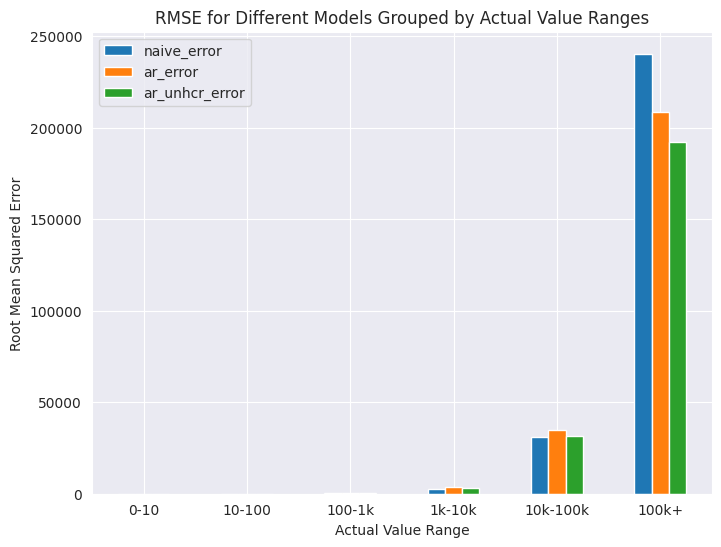

In [98]:
# Plot the bar plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
grouped_errors.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

## Continents

In [99]:
continents = df_forecast[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'continent_o'}, axis=1)
df_forecast = pd.concat([continents, df_forecast], axis=1)
df_forecast

,continent_o,iso_o,iso_d,year,Id,newarrival,fcast_naive,fcast_ar,fcast_ar_unhcr
0,NA,ABW,AFG,2000,ABWAFG,0.0,NaN,NaN,NaN
1,NA,ABW,AFG,2001,ABWAFG,0.0,NaN,NaN,NaN
2,NA,ABW,AFG,2002,ABWAFG,0.0,NaN,NaN,NaN
3,NA,ABW,AFG,2003,ABWAFG,0.0,NaN,NaN,NaN
4,NA,ABW,AFG,2004,ABWAFG,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
840835,AF,ZWE,ZMB,2017,ZWEZMB,0.0,NaN,NaN,NaN
840836,AF,ZWE,ZMB,2018,ZWEZMB,2.0,0.0,2.324000,0.133333
840837,AF,ZWE,ZMB,2019,ZWEZMB,0.0,2.0,1.046909,1.159444
840838,AF,ZWE,ZMB,2020,ZWEZMB,1.0,0.0,1.818719,0.793960


In [100]:
# Define a custom aggregation function to sum while considering NaN values
def sum_with_nan(series):
    return series.sum(min_count=1)

# Group the DataFrame by "continent_o" and "year", and apply the custom aggregation function to the desired variables
grouped = df_forecast.groupby(['continent_o', 'year'])['newarrival', 'fcast_naive', 'fcast_ar','fcast_ar_unhcr'].agg(sum_with_nan)

# Reset the index to have "continent_o" and "year" as columns
grouped = grouped.reset_index()
grouped

/tmp/ipykernel_446105/937589183.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = df_forecast.groupby(['continent_o', 'year'])['newarrival', 'fcast_naive', 'fcast_ar','fcast_ar_unhcr'].agg(sum_with_nan)


,continent_o,year,newarrival,fcast_naive,fcast_ar,fcast_ar_unhcr
0,AF,2000,645426.0,NaN,NaN,NaN
1,AF,2001,416741.0,NaN,NaN,NaN
2,AF,2002,568101.0,NaN,NaN,NaN
3,AF,2003,515585.0,NaN,NaN,NaN
4,AF,2004,406924.0,NaN,NaN,NaN
...,...,...,...,...,...,...
127,SA,2017,156109.0,NaN,NaN,NaN
128,SA,2018,2545005.5,156109.0,1.264658e+05,1.196089e+05
129,SA,2019,1594536.0,2545005.5,1.706120e+06,1.500987e+06
130,SA,2020,635905.0,1594536.0,1.669603e+06,1.120400e+06


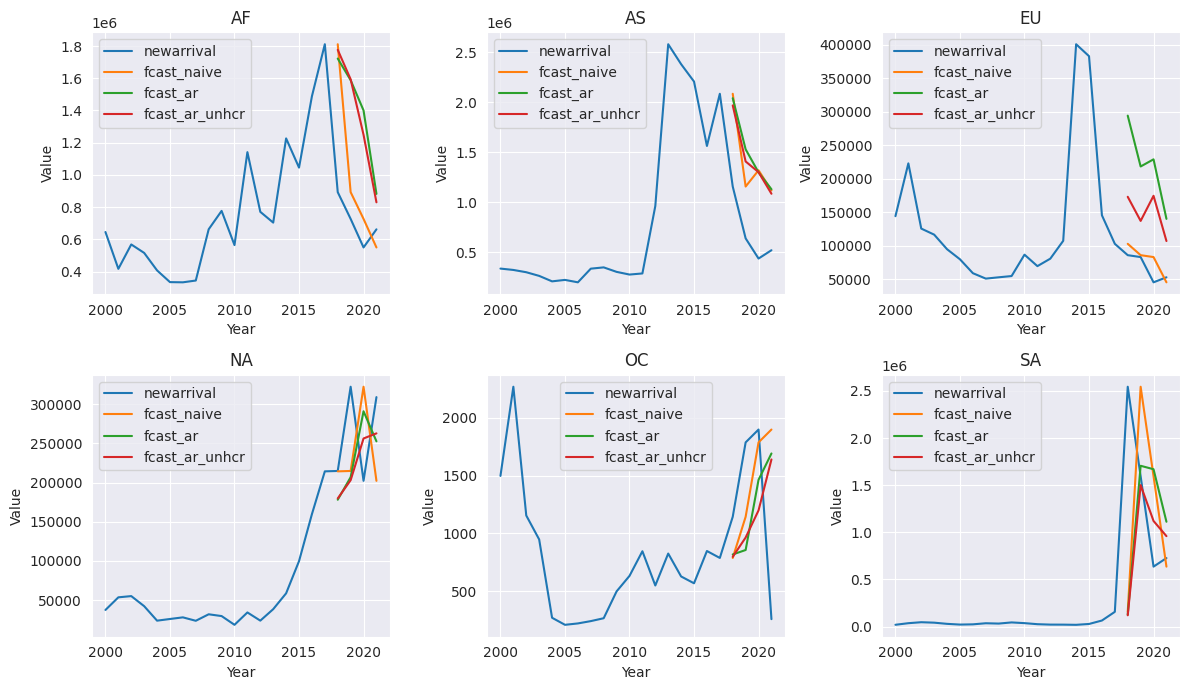

In [108]:
# Get the unique continents in the DataFrame
continents = grouped['continent_o'].unique()

# Set the number of rows and columns for the subplot grid
num_rows = 2  # Adjust the number of rows as per your preference
num_cols = (len(continents) + num_rows - 1) // num_rows

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 7))

# Flatten the subplot grid to access each individual subplot
axes = axes.flatten()

# Iterate over the unique continents and plot the data for each continent
for i, continent in enumerate(continents):
    # Filter the DataFrame for the current continent
    continent_grouped = grouped[grouped['continent_o'] == continent]
    
    # Plot the data for "newarrival" and "fcast_newarrival_naive" for the current continent
    axes[i].plot(continent_grouped['year'], continent_grouped['newarrival'], label='newarrival')
    axes[i].plot(continent_grouped['year'], continent_grouped['fcast_naive'], label='fcast_naive')
    axes[i].plot(continent_grouped['year'], continent_grouped['fcast_ar'], label='fcast_ar')
    axes[i].plot(continent_grouped['year'], continent_grouped['fcast_ar_unhcr'], label='fcast_ar_unhcr')
    
    # Set the title and labels for the current subplot
    axes[i].set_title(continent)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')
    
    # Display the legend for the current subplot
    axes[i].legend()

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

## Dyad level

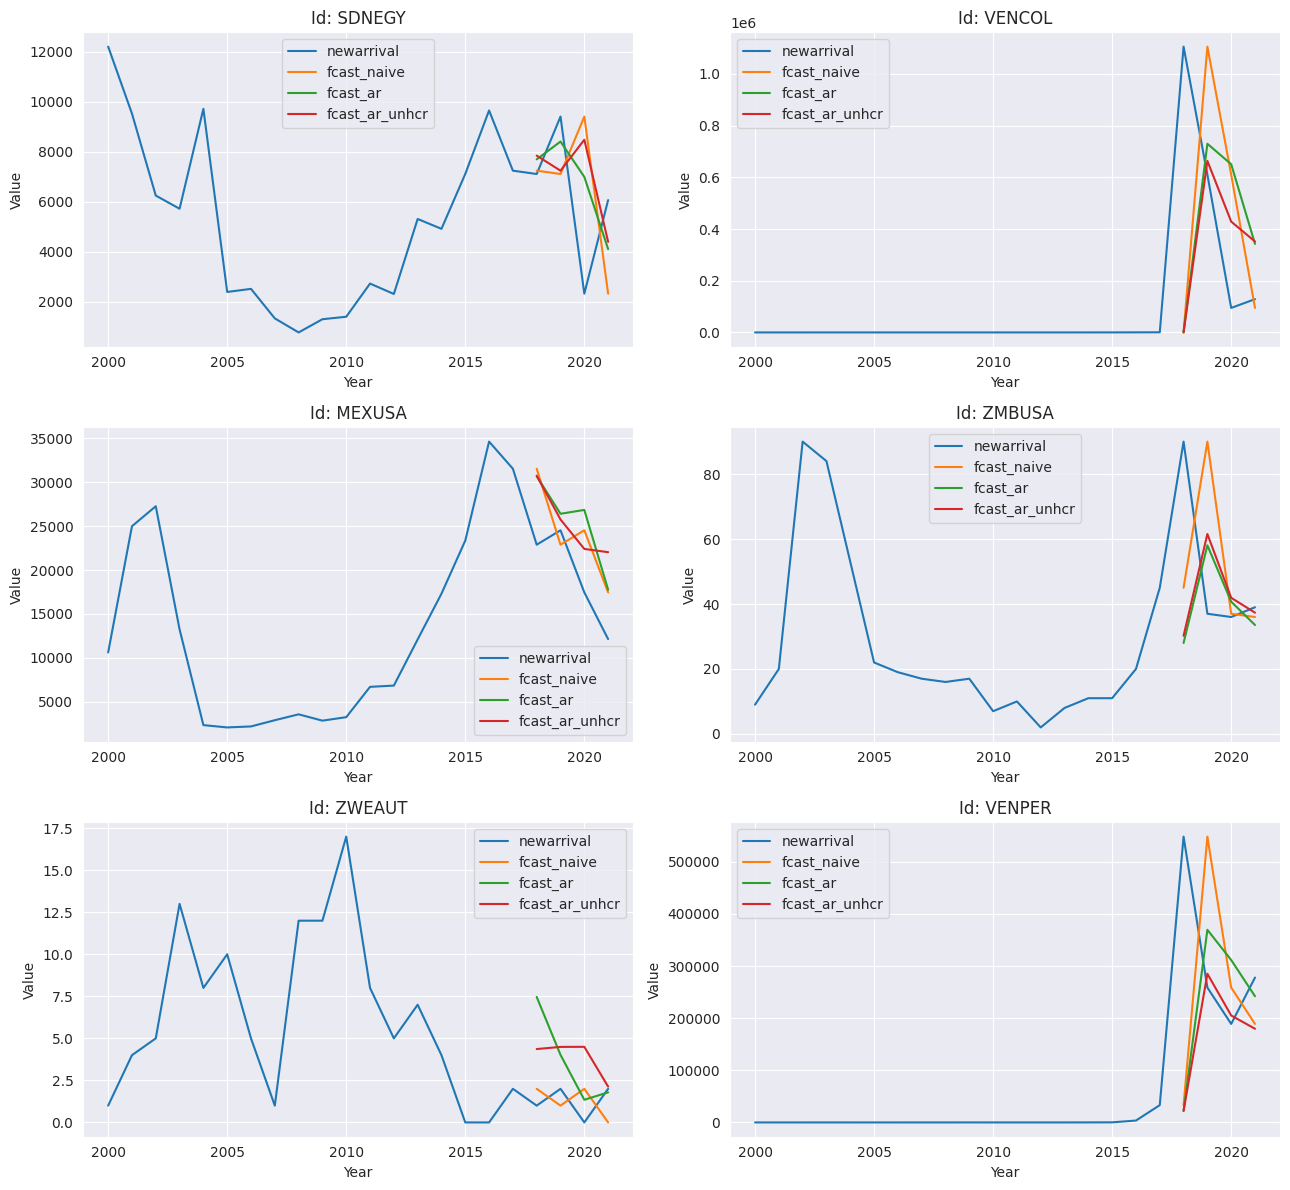

In [102]:
# Selected Ids 
unique_ids = ['SDNEGY','VENCOL','MEXUSA','ZMBUSA','ZWEAUT','VENPER']

# Create a figure with subplots for each "Id"
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 12))

# Iterate over the unique "Id" values and plot the data
for i, id_value in enumerate(unique_ids):
    # Select the data for the current "Id"
    data = df_forecast[df_forecast['Id'] == id_value]
    
    # Get the corresponding subplot axis
    #ax = axes[i]
    ax = axes[i // 2, i % 2]
    
    # Plot "newarrival" and "fcast_newarrival_ar" values over time
    ax.plot(data['year'], data['newarrival'], label='newarrival')
    ax.plot(data['year'], data['fcast_naive'], label='fcast_naive')
    ax.plot(data['year'], data['fcast_ar'], label='fcast_ar')
    ax.plot(data['year'], data['fcast_ar_unhcr'], label='fcast_ar_unhcr')
    
    # Set plot title and axis labels
    ax.set_title(f'Id: {id_value}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    
    # Display legend
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
